In [19]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 1)
date_to = dt.date(2023, 6, 14)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)
players = u.to_players(battles)

### ブキ統計量を求める

- 1分あたりのキル
- 1分あたりのアシスト
- 1分あたりのデス
- 1分あたりのスペシャル
- 1分あたりの塗り面積


In [20]:
result_cols = ["kill", "assist", "death", "special", "inked"]
weapon_stat = players.groupby(["mode", "weapon"])[result_cols + ["time"]].sum()

for col in result_cols:
    weapon_stat[col] = weapon_stat[col] / weapon_stat["time"] * 60

weapon_stat = weapon_stat.drop(columns="time")
weapon_stat = weapon_stat.groupby("weapon").mean()
weapon_stat

,kill,assist,death,special,inked
weapon,,,,,
52gal,1.662113,0.406404,1.647490,0.838332,231.870260
96gal,1.470837,0.437086,1.261654,0.827837,259.531617
96gal_deco,1.569162,0.316139,1.305161,0.690622,223.145811
bamboo14mk1,1.307707,0.586563,1.240220,0.904199,229.413370
barrelspinner,1.147344,0.565922,1.163765,0.914489,259.036015
...,...,...,...,...,...
tristringer,0.970064,0.795019,0.955157,1.036257,235.326688
variableroller,1.385067,0.395142,1.326501,0.965908,296.640708
wakaba,1.194069,0.486729,1.332468,0.918363,296.239004


### 相関係数を確認する

In [21]:
weapon_stat.corr()

,kill,assist,death,special,inked
kill,1.000000,-0.370786,0.657221,-0.572532,-0.483221
assist,-0.370786,1.000000,-0.142762,0.286020,0.169280
death,0.657221,-0.142762,1.000000,-0.406555,-0.246057
special,-0.572532,0.286020,-0.406555,1.000000,0.862914
inked,-0.483221,0.169280,-0.246057,0.862914,1.000000


### 主成分分析を行う

In [22]:
from sklearn.decomposition import PCA

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

df = weapon_stat.reset_index()
df_z = df.iloc[:,1:].apply(standardize)
dimension = len(df_z.columns)
pc_cols = [f"pc{x+1}" for x in range(dimension)]

pca = PCA()
pca.fit(df_z)

# 各ブキの主成分を求める
score = pd.DataFrame(pca.transform(df_z), columns=pc_cols)
score = pd.concat([df.iloc[:,:1], score], axis=1)
score = score.set_index("weapon")

# 累積寄与率 cc_ratio を求める
ev_ratio = pd.DataFrame(pca.explained_variance_ratio_, index=pc_cols)
cc_ratio = ev_ratio.cumsum().T

# 主成分負荷量 eigen_vector を求める
eigen_vector = pd.DataFrame(pca.components_, columns=df_z.columns, index=pc_cols)

cc_ratio

,pc1,pc2,pc3,pc4,pc5
0,0.554253,0.746498,0.922027,0.977692,1.0


### 可視化する

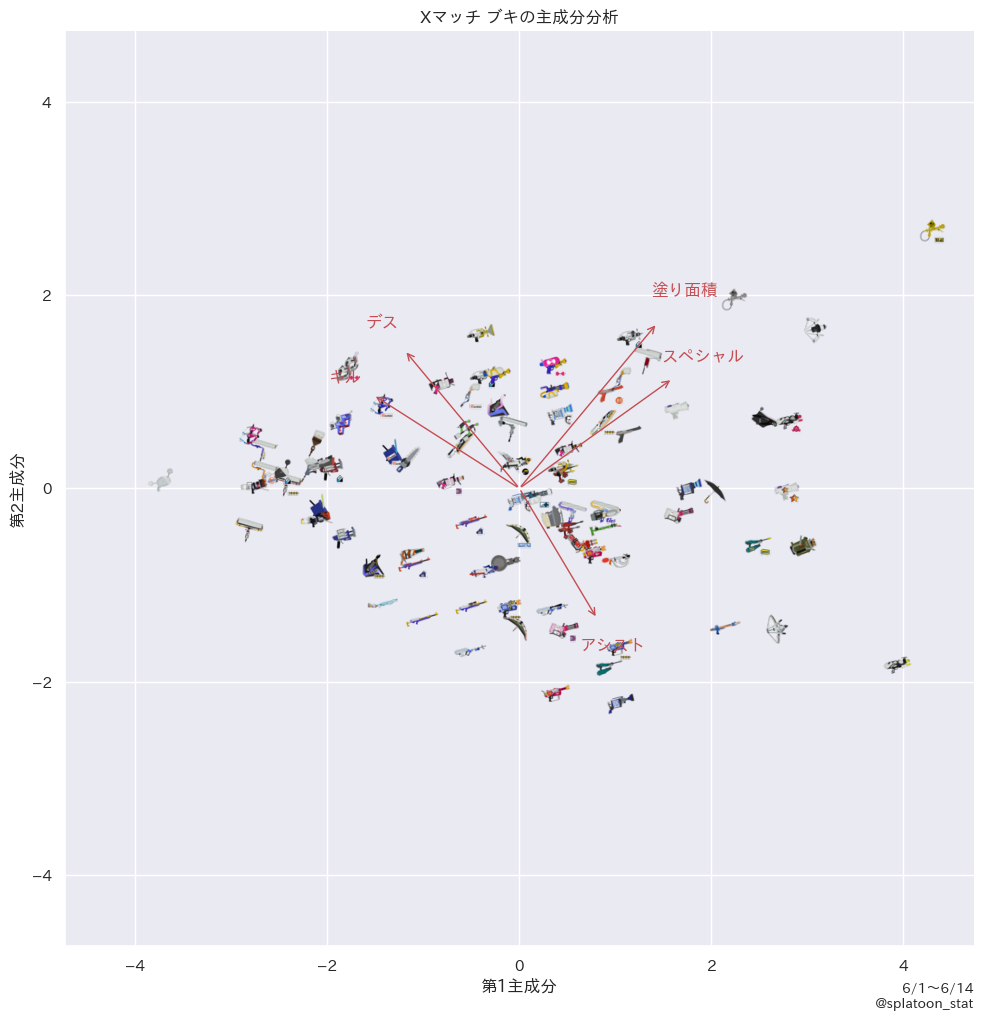

In [23]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "${lobby} ブキの主成分分析", "Weapon PCA in ${lobby}")
i18n.add("pc1", "第1主成分", "1st component")
i18n.add("pc2", "第2主成分", "2nd component")
i18n.add("kill", "キル", "Kill")
i18n.add("assist", "アシスト", "Assist")
i18n.add("death", "デス", "Death")
i18n.add("special", "スペシャル", "Special")
i18n.add("inked", "塗り面積", "Inked")

value_range = max(score[["pc1", "pc2"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=score,
    x="pc1",
    y="pc2",
    marker="",
    height=10,
)
ax = g.ax

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("pc1"),
    ylabel=i18n.t("pc2"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, row in score.iterrows():
    weapon = row.name
    xvalue = row["pc1"]
    yvalue = row["pc2"]
    image_path = image.get_image_path(weapon)
    im = plt.imread(image_path)
    img = OffsetImage(im, zoom=0.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
    ax.add_artist(ab)

for col, item in eigen_vector.items():
    mag = 3
    vec = [item["pc1"], item["pc2"]]
    ax.annotate("", (0, 0), xytext=[x * mag for x in vec], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
    ax.annotate(i18n.t(col), (0, 0), xytext=[x * mag * 1.2 for x in vec], color="r", ha="center", va="center")

u.credit(ax, g.fig, i18n.t_data_duration(battles))
plt.show()


In [24]:
score

,pc1,pc2,pc3,pc4,pc5
weapon,,,,,
52gal,-0.815184,1.087189,0.027827,-0.274242,-0.461569
96gal,0.505806,0.407769,-0.777349,-0.590248,0.288438
96gal_deco,-0.718302,0.073448,-1.205129,-0.481530,0.147654
bamboo14mk1,0.889497,-0.407927,-0.358464,-0.432783,-0.454497
barrelspinner,1.660970,-0.263470,-0.638311,-0.135043,-0.010287
...,...,...,...,...,...
tristringer,2.684889,-1.450742,-0.314544,-0.484343,-0.637070
variableroller,1.332812,1.326002,-0.726016,-0.345825,0.273547
wakaba,1.647455,0.821461,-0.474412,0.185597,0.427268


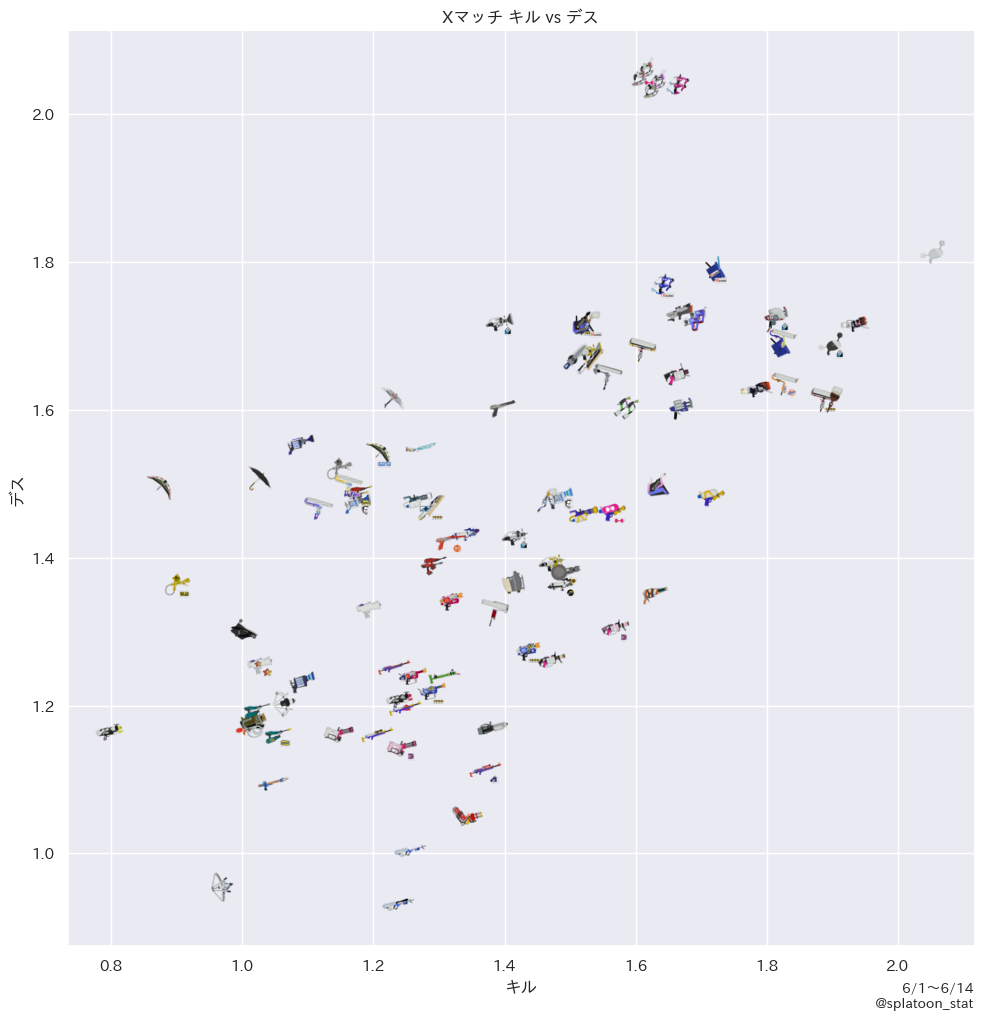

In [51]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "${lobby} キル vs デス", "Kill vs Death in ${lobby}")
i18n.add("kill", "キル", "Kill")
i18n.add("death", "デス", "Death")

g = sns.relplot(
    data=weapon_stat,
    x="kill",
    y="death",
    marker="",
    height=10,
)
ax = g.ax

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("kill"),
    ylabel=i18n.t("death"),
)

for weapon, row in weapon_stat.iterrows():
    xvalue = row["kill"]
    yvalue = row["death"]
    image_path = image.get_image_path(weapon)
    im = plt.imread(image_path)
    img = OffsetImage(im, zoom=0.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
    ax.add_artist(ab)

u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()

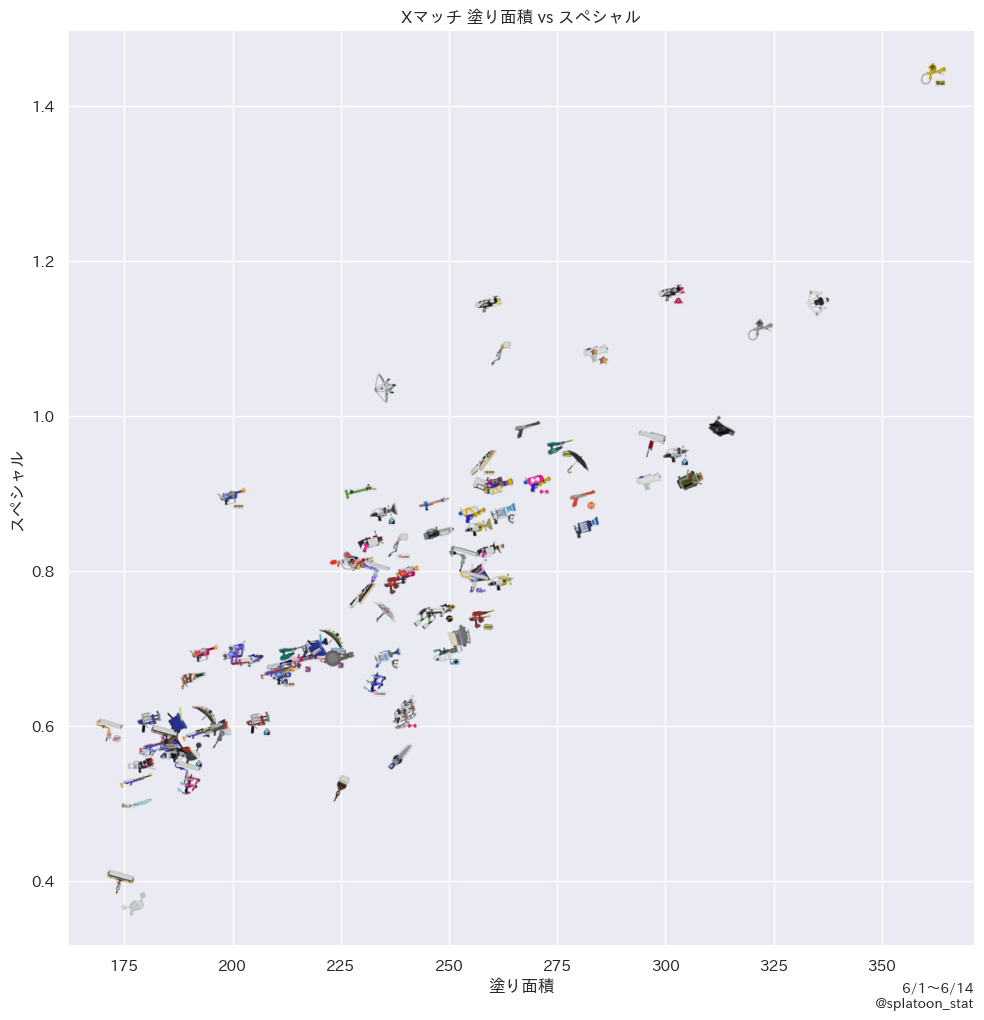

In [52]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "${lobby} 塗り面積 vs スペシャル", "Inked vs Special in ${lobby}")
i18n.add("inked", "塗り面積", "Inked")
i18n.add("special", "スペシャル", "Special")

g = sns.relplot(
    data=weapon_stat,
    x="inked",
    y="special",
    marker="",
    height=10,
)
ax = g.ax

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("inked"),
    ylabel=i18n.t("special"),
)

for weapon, row in weapon_stat.iterrows():
    xvalue = row["inked"]
    yvalue = row["special"]
    image_path = image.get_image_path(weapon)
    im = plt.imread(image_path)
    img = OffsetImage(im, zoom=0.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
    ax.add_artist(ab)

u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()